# 008.001 Features - Poisson Regression

In [1]:
import pathlib
import sys

import pandas as pd
import numpy as np

import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson, nbinom


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload all modules
%autoreload 2
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

from src.visualization.visualize import (extend_cols,
                                         vstacked_bar_charts,
                                         diagnose_discrete_fit)
from src.visualization.fit_dists import fit_nbinom

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

fn = '2007-2008__2017-2018.csv'
EDA_FP = PROJECT_DIR / 'data' / 'sample' / '01-stacked-seasons' / 'germany' / 'bundesliga' / fn
SAVED_IMAGES_DIR = PROJECT_DIR / 'notebooks' / 'saved-images'

## Methodology - Modified from David Sheehan's Code

This web page runs through a method for running a poisson regression on league football data:

[David Sheehan - Predicting Football Results with Statistical Modeling](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/)

I will directly lift David's code and wrap it in a sklearn classifier wrapper.

I'll also code up a step forward tome series cross validation scheme for a football league

## Load Sample Data

In [2]:
df_orig = pd.read_csv(EDA_FP, parse_dates=['date'])
df_orig = df_orig[~df_orig['season'].isin(['2015-2016', '2016-2017', '2017-2018'])]
cols = ['season', 'date', 'h', 'a', 'h_ftGoals', 'a_ftGoals', 'result']
df_orig = df_orig[cols].sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
df_orig.head(2)

,season,date,h,a,h_ftGoals,a_ftGoals,result
0,2007-2008,2007-08-10,stuttgart,schalke,2.0,2.0,draw
1,2007-2008,2007-08-11,bayern-munich,hansa-rostock,3.0,0.0,hwin


In [3]:
df_orig.tail(2)

,season,date,h,a,h_ftGoals,a_ftGoals,result
2446,2014-2015,2015-05-23,hoffenheim,hertha-berlin,2.0,1.0,hwin
2447,2014-2015,2015-05-23,paderborn,stuttgart,1.0,2.0,awin


In [4]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448 entries, 0 to 2447
Data columns (total 7 columns):
season       2448 non-null object
date         2448 non-null datetime64[ns]
h            2448 non-null object
a            2448 non-null object
h_ftGoals    2448 non-null float64
a_ftGoals    2448 non-null float64
result       2448 non-null object
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 134.0+ KB


## Implementation Notes

+ Season Splitter - Each seson will be treated as independent of every other season. No data from previous seasons will be used to inform decisions regarding the next season
+ Time Series Step Forward Cross Validation Splitter - We only want to make predictions on future games using data from past games. The fixture list will be split into game days. Team's playing on a game day will be be rated using ALL of the current season's previous games.

### Split Into Seasons

In [5]:
def get_season_df(multi_season_df):
    """
    Accepts a Dataframe with multiple season data where each season
    is identified by a sortable value such as '2007-2008', '2008-2009'
    and the df has a date type column with a column name date
    Yields dataframes for each season in time order - earliest to latest
    with a new integer index
    """
    df = multi_season_df.copy()
    for season in sorted(df['season'].unique()):
        season_df = df.loc[df['season'] == season]
        season_df = season_df.sort_values(by=['date']).reset_index(drop=True)
        yield season_df

In [6]:
for season_df in get_season_df(df_orig):
    print(season_df['season'].unique())

['2007-2008']
['2008-2009']
['2009-2010']
['2010-2011']
['2011-2012']
['2012-2013']
['2013-2014']
['2014-2015']


### Split Seasons into Prediction Sets

In [7]:
# Grab a single Season
n = 0
for season_df in get_season_df(df_orig):
    df = season_df
    n += 1
    if n == 4:
        break

In [8]:
df.head(2)

,season,date,h,a,h_ftGoals,a_ftGoals,result
0,2010-2011,2010-08-20,bayern-munich,wolfsburg,2.0,1.0,hwin
1,2010-2011,2010-08-21,borussia-monchengladbach,nurnberg,1.0,1.0,draw


In [9]:
df.tail(2)

,season,date,h,a,h_ftGoals,a_ftGoals,result
304,2010-2011,2011-05-14,hamburger-sv,borussia-monchengladbach,1.0,1.0,draw
305,2010-2011,2011-05-14,sc-freiburg,leverkusen,0.0,1.0,awin


In [10]:
def insert_game_day(df_orig):
    """
    Accepts a dataframe for a single league season
    Numbers each game day in the season
    where a game daya is a day within the season time period where
    one or more games are played
    Returns a new dataframe
    """
    df = df_orig.copy(deep=True)
    df['game_day'] = df.groupby(by='date').ngroup(ascending=True)
    return df

In [11]:
df2 = insert_game_day(df)
df2.head(11)

,season,date,h,a,h_ftGoals,a_ftGoals,result,game_day
0,2010-2011,2010-08-20,bayern-munich,wolfsburg,2.0,1.0,hwin,0
1,2010-2011,2010-08-21,borussia-monchengladbach,nurnberg,1.0,1.0,draw,1
2,2010-2011,2010-08-21,fc-koln,kaiserslautern,1.0,3.0,awin,1
3,2010-2011,2010-08-21,hamburger-sv,schalke,2.0,1.0,hwin,1
4,2010-2011,2010-08-21,hannover,eintracht-frankfurt,2.0,1.0,hwin,1
5,2010-2011,2010-08-21,hoffenheim,sv-werder-bremen,4.0,1.0,hwin,1
6,2010-2011,2010-08-21,sc-freiburg,st-pauli,1.0,3.0,awin,1
7,2010-2011,2010-08-22,mainz,stuttgart,2.0,0.0,hwin,2
8,2010-2011,2010-08-22,dortmund,leverkusen,0.0,2.0,awin,2
9,2010-2011,2010-08-27,kaiserslautern,bayern-munich,2.0,0.0,hwin,3


In [12]:
df2.tail()

,season,date,h,a,h_ftGoals,a_ftGoals,result,game_day
301,2010-2011,2011-05-14,fc-koln,schalke,2.0,1.0,hwin,94
302,2010-2011,2011-05-14,dortmund,eintracht-frankfurt,3.0,1.0,hwin,94
303,2010-2011,2011-05-14,bayern-munich,stuttgart,2.0,1.0,hwin,94
304,2010-2011,2011-05-14,hamburger-sv,borussia-monchengladbach,1.0,1.0,draw,94
305,2010-2011,2011-05-14,sc-freiburg,leverkusen,0.0,1.0,awin,94


In [13]:
class LeagueSeasonTimeSeriesFold():
    """
    Accepts a league season date sorted DataFrame containing a game_day column
    """
   
    def get_game_day_change_indices(self, X_df):
        return X_df['game_day'].diff()[X_df['game_day'].diff() != 0].index.values

    def split(self, X_df, y=None, groups=None):
        """
        Accepts a dataframe for a season with a 'game_day' column
        Splits into train, test for each game day in the season
        """
        game_day_indices = self.get_game_day_change_indices(X_df)
        for gd_index in game_day_indices[1:]:
            n_game_day = X_df.loc[gd_index]['game_day']
            train_indices = X_df[X_df['game_day'] < n_game_day].index
            test_indices = X_df[X_df['game_day'] == n_game_day].index
            yield train_indices, test_indices

In [14]:
splitter = LeagueSeasonTimeSeriesFold()

n = 0
for train_indices, test_indices in splitter.split(df2):
    print(f'Train: {train_indices}\nTest: {test_indices}\n')
    n += 1
    if n == 4:
        break

Train: Int64Index([0], dtype='int64')
Test: Int64Index([1, 2, 3, 4, 5, 6], dtype='int64')

Train: Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
Test: Int64Index([7, 8], dtype='int64')

Train: Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')
Test: Int64Index([9], dtype='int64')

Train: Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')
Test: Int64Index([10, 11, 12, 13, 14, 15], dtype='int64')



### Wrap Poisson Regression in SKLearn Wrapper

In [15]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.multiclass import unique_labels

import pandas as pd
import numpy as np
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.sm_exceptions as sm_exceptions


class PoissonRegression(BaseEstimator, ClassifierMixin):
    """
    Adapted from:
    https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/
    fit accepts a DataFrame representing an early part of a league season
    Reshapes the data, and fits a Regression Model based on this data
    predict / predict_proba accepts a dataFrame representing a later,
    consecutive part of a league season.
    Reshapes the data and makes, and returns
    home win, draw, and away win probabilities

    DataFrame must have the following data columns
    h - home team, a - away team
    h_ftGoals - home team full time goals
    a_ftGoals - away team full time goals
    """
    def __init__(self, family=sm.families.Poisson(),
                 formula='goals ~ home + team + opponent',
                 max_goals=10):
        self.family = family
        self.formula = formula
        self.max_goals = max_goals
        self.epsilon = 0.1
        self.model = None

    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : Not used
        Returns
        -------
        self : object
            Returns self.
        """
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y

        # Reshape the data
        self.reshaped_X_ = pd.concat([self.X_[['h', 'a', 'h_ftGoals']].assign(home=1).rename(
                             columns={'h': 'team', 'a': 'opponent', 'h_ftGoals': 'goals'}),
                             self.X_[['a', 'h', 'a_ftGoals']].assign(home=0).rename(
                             columns={'a': 'team', 'h': 'opponent', 'a_ftGoals': 'goals'})])
        # print(self.reshaped_X_.head())
        # fit the model - have to handle perfect separation or not enough data
        # If exception - catch and the the model to None
        # If we see  None model in predict, we can return np.NaN probabilities
        # to show that the model did not do the prediction
        try:
            self.model = smf.glm(formula=self.formula,
                                 data=self.reshaped_X_,
                                 family=self.family).fit()
        except sm_exceptions.PerfectSeparationError:
            # print('sm_exceptions.PerfectSeparationError')
            self.model = None
        except ValueError:
            # print('ValueError')
            self.model = None
        # Return the classifier
        return self.model

    def calc_probas(self, row):
        team_pred = [[poisson.pmf(i, team_avg) for i in range(0, self.max_goals+1)]
                     for team_avg in [row['h_lambda'], row['a_lambda']]]
        prob_table = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
        phwin = np.sum(np.tril(prob_table, -1))
        pdraw = np.sum(np.diag(prob_table))
        pawin = np.sum(np.triu(prob_table, 1))
        # Return in same sequence as classes_
        return phwin, pdraw, pawin

    def predict(self, X):
        """ A reference implementation of a prediction for a classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        if self.model is not None:
            # Reshape the data and make the poisson predictions
            h_preds = self.model.predict(pd.DataFrame(data={'team': X['h'].values,
                                                      'opponent': X['a'].values,
                                                            'home': 1}))
            a_preds = self.model.predict(pd.DataFrame(data={'team': X['a'].values,
                                                      'opponent': X['h'].values,
                                                            'home': 0}))
            temp_df = pd.DataFrame({'h_lambda': h_preds, 'a_lambda': a_preds})
            self.probas = temp_df.apply(self.calc_probas, axis=1, result_type='expand')
            self.probas.columns = ['poiss_p(hwin)', 'poiss_p(draw)', 'poiss_p(awin)']
        else:
            self.probas = pd.DataFrame({'poiss_p(hwin)': [np.NaN]*len(X),
                                        'poiss_p(draw)': [np.NaN]*len(X),
                                        'poiss_p(awin)': [np.NaN]*len(X)})

        # When there is not enough data to predict, the model can
        # create some non-sensical probabilities
        # Clean these up by setting all 3 probabilities to np.NaN
        crit1 = self.probas.sum(axis=1) < 1.0 - self.epsilon
        crit2 = self.probas.sum(axis=1) > 1.0 + self.epsilon
        self.probas[crit1 | crit2] = np.NaN
        # Set the index of the returned probabilities to match the input data
        self.probas.index = X.index

        return self.probas.idxmax(axis=1)

    def predict_proba(self, X):
        self.predict(X)

        rename_dict = {'poiss_p(hwin)': 'h_poissWin',
                       'poiss_p(draw)': 'h_poissDraw',
                       'poiss_p(awin)': 'h_poissLose'}
        self.probas.rename(columns=rename_dict, inplace=True)
        self.probas['a_poissDraw'] = self.probas['h_poissDraw']
        self.probas['a_poissWin'] = self.probas['h_poissLose']
        self.probas['a_poissLose'] = self.probas['h_poissWin']

        return self.probas

## Apply Model to a Sample Season

In [16]:
def run_poisson_regression(df_orig):
    df = df_orig.copy(deep=True)
    df.reset_index(drop=True, inplace=True)
    game_day_splitter = LeagueSeasonTimeSeriesFold()
    for train_indices, predict_indices in game_day_splitter.split(df):
        clf = PoissonRegression()
        clf.fit(df.loc[train_indices], df.loc[train_indices, 'result'])
        preds = clf.predict_proba(df.loc[predict_indices])
        for i, col in enumerate(preds.columns):
            df.loc[predict_indices, preds.columns[i]] = \
                preds[preds.columns[i]].values
    return df

In [17]:
proba_df = run_poisson_regression(df2)
proba_df.head(10)



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/regression/_tools.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  scale = np.dot(wresid, wresid) / df_resid
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:521: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:134: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:1163: RuntimeWarning: i

,season,date,h,a,h_ftGoals,a_ftGoals,result,game_day,h_poissWin,h_poissDraw,h_poissLose,a_poissDraw,a_poissWin,a_poissLose
0,2010-2011,2010-08-20,bayern-munich,wolfsburg,2.0,1.0,hwin,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-2011,2010-08-21,borussia-monchengladbach,nurnberg,1.0,1.0,draw,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-2011,2010-08-21,fc-koln,kaiserslautern,1.0,3.0,awin,1,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-2011,2010-08-21,hamburger-sv,schalke,2.0,1.0,hwin,1,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-2011,2010-08-21,hannover,eintracht-frankfurt,2.0,1.0,hwin,1,NaN,NaN,NaN,NaN,NaN,NaN
5,2010-2011,2010-08-21,hoffenheim,sv-werder-bremen,4.0,1.0,hwin,1,NaN,NaN,NaN,NaN,NaN,NaN
6,2010-2011,2010-08-21,sc-freiburg,st-pauli,1.0,3.0,awin,1,NaN,NaN,NaN,NaN,NaN,NaN
7,2010-2011,2010-08-22,mainz,stuttgart,2.0,0.0,hwin,2,NaN,NaN,NaN,NaN,NaN,NaN
8,2010-2011,2010-08-22,dortmund,leverkusen,0.0,2.0,awin,2,NaN,NaN,NaN,NaN,NaN,NaN
9,2010-2011,2010-08-27,kaiserslautern,bayern-munich,2.0,0.0,hwin,3,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
proba_df.tail(10)

,season,date,h,a,h_ftGoals,a_ftGoals,result,game_day,h_poissWin,h_poissDraw,h_poissLose,a_poissDraw,a_poissWin,a_poissLose
296,2010-2011,2011-05-07,wolfsburg,kaiserslautern,1.0,2.0,awin,93,0.438378,0.264129,0.297492,0.264129,0.297492,0.438378
297,2010-2011,2011-05-14,hoffenheim,wolfsburg,1.0,3.0,awin,94,0.517836,0.246596,0.235566,0.246596,0.235566,0.517836
298,2010-2011,2011-05-14,kaiserslautern,sv-werder-bremen,3.0,2.0,hwin,94,0.530589,0.225077,0.244329,0.225077,0.244329,0.530589
299,2010-2011,2011-05-14,hannover,nurnberg,3.0,1.0,hwin,94,0.432715,0.269763,0.297522,0.269763,0.297522,0.432715
300,2010-2011,2011-05-14,mainz,st-pauli,2.0,1.0,hwin,94,0.737510,0.166233,0.096223,0.166233,0.096223,0.737510
301,2010-2011,2011-05-14,fc-koln,schalke,2.0,1.0,hwin,94,0.399505,0.265247,0.335248,0.265247,0.335248,0.399505
302,2010-2011,2011-05-14,dortmund,eintracht-frankfurt,3.0,1.0,hwin,94,0.775836,0.171963,0.052192,0.171963,0.052192,0.775836
303,2010-2011,2011-05-14,bayern-munich,stuttgart,2.0,1.0,hwin,94,0.760606,0.126605,0.112063,0.126605,0.112063,0.760606
304,2010-2011,2011-05-14,hamburger-sv,borussia-monchengladbach,1.0,1.0,draw,94,0.550841,0.209695,0.239451,0.209695,0.239451,0.550841
305,2010-2011,2011-05-14,sc-freiburg,leverkusen,0.0,1.0,awin,94,0.301328,0.239545,0.459125,0.239545,0.459125,0.301328


In [19]:
proba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 14 columns):
season         306 non-null object
date           306 non-null datetime64[ns]
h              306 non-null object
a              306 non-null object
h_ftGoals      306 non-null float64
a_ftGoals      306 non-null float64
result         306 non-null object
game_day       306 non-null int64
h_poissWin     280 non-null float64
h_poissDraw    280 non-null float64
h_poissLose    280 non-null float64
a_poissDraw    280 non-null float64
a_poissWin     280 non-null float64
a_poissLose    280 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(4)
memory usage: 33.6+ KB


### Explanation

For reasons that will be clarified later, the model returns 3 probabilities duplicated twice - once for the home team, and once for the away team

For the purposes of clear explanation, we will rename the probabilities, and drop the duplicates.
We will have 3 probabilities 
+ 1 - probability of a home win
+ 2 - probability of a draw
+ 3 - probability of an away win

Alos, note that for the first few game days, there is not enough history (data) to allow the poisson regression to run, so we have got NaNs for these probabilities at the start of the season - We will drop these.

In [20]:
proba_df.rename(columns={'h_poissWin': 1, 'h_poissDraw': 2, 'h_poissLose': 3}, inplace=True)
proba_df.drop(columns=['a_poissWin','a_poissDraw','a_poissLose'], inplace=True)
proba_df.dropna(subset=[1, 2, 3], inplace=True)
proba_df.head()

,season,date,h,a,h_ftGoals,a_ftGoals,result,game_day,1,2,3
17,2010-2011,2010-08-29,stuttgart,dortmund,1.0,3.0,awin,5,2.836877e-08,0.995539,0.004461
25,2010-2011,2010-09-12,fc-koln,st-pauli,1.0,0.0,hwin,8,1.415839e-01,0.284044,0.574372
26,2010-2011,2010-09-12,mainz,kaiserslautern,2.0,1.0,hwin,8,1.288736e-03,0.005625,0.926198
27,2010-2011,2010-09-17,eintracht-frankfurt,sc-freiburg,0.0,1.0,awin,9,8.731624e-01,0.070419,0.050187
28,2010-2011,2010-09-18,bayern-munich,fc-koln,0.0,0.0,draw,10,2.373952e-01,0.245249,0.517354


We will also create some helper columns

In [21]:
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder


def encode_result(df_orig):
    """
    Accepts a DataFrame containing a column named "result"
    which can only contain the following categories:
    + hwin
    + draw
    + awin
    Creates a new column named "ordinal result"
    where these are mapped to corresponding integer values
    + 1
    + 2
    + 3
    Returns a new DataFrame
    """
    df = df_orig.copy(deep=True)
    mapping_dict = {'col': 'result', 'mapping': {'hwin': 1,
                                                 'draw': 2,
                                                 'awin': 3}}
    ord_enc = OrdinalEncoder(mapping=[mapping_dict])
    df['ordinal_result'] = ord_enc.fit_transform(df[['result']])
    return df


def one_hot_encoded_result(df_orig):
    """
    Accepts a dataFrame containing a column named "ordinal_result"
    which contains 3 integers representing 3 categories
    + 1 - Home Win
    + 2 - Draw
    + 3 - Away Win
    One Hot Encodes this column to 3 columns
    ordinal_result_1
    ordinal_result_2
    ordinal_result_3
    Returns a new DataFrame    
    """
    df = df_orig.copy(deep=True)
    one_hot_enc = OneHotEncoder(cols=['ordinal_result'], use_cat_names=True)
    one_hot_cols = one_hot_enc.fit_transform(df[['ordinal_result']])
    new_one_hot_col_names = [col[:-2] for col in one_hot_cols.columns]
    mapping_dict = {old: new for old, new in zip(one_hot_cols.columns,
                                                 new_one_hot_col_names)}
    one_hot_cols.rename(columns=mapping_dict, inplace=True)
    one_hot_cols = one_hot_cols[sorted(one_hot_cols.columns)]
    df_with_new_cols = pd.concat([df, one_hot_cols], axis=1)
    return df_with_new_cols


def insert_rps(df_orig, prob_cols=[1,2,3], return_col_prefix='model'):
    """
    Accepts a DataFram containing the following 6 columns
    ordinal_result_1, ordinal_result_2, ordinal_result_3
    and corresponding columns named 1, 2, and 3
    ordinal result columns are binary columns 
    1, 2, 3 columns contain probailities
    1 represents Home Win
    2 represents Draw
    3 represents Away Win
    Calculates an Rank Probability Score for each instance, inserts these
    into a column named "rps"
    Returns the new DataFrame
    """
    df = df_orig.copy(deep=True)
    obs_df = df[['ordinal_result_1', 'ordinal_result_2', 'ordinal_result_3']]
    pred_df = df[prob_cols]
    pred_cdf = pred_df.cumsum(axis=1).values
    obs_cdf = obs_df.cumsum(axis=1).values
    df[return_col_prefix + '_rps'] = np.sum(1/(pred_df.shape[1]-1) * (pred_cdf - obs_cdf)**2, 1)
    return df

In [22]:
df_plus = proba_df.copy(deep=True)
df_plus = encode_result(df_plus)
df_plus = one_hot_encoded_result(df_plus)
df_plus = insert_rps(df_plus)
df_plus.rename(columns={'rps': 'model_rps'})
df_plus.head(6)

,season,date,h,a,h_ftGoals,a_ftGoals,result,game_day,1,2,3,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,model_rps
17,2010-2011,2010-08-29,stuttgart,dortmund,1.0,3.0,awin,5,2.836877e-08,0.995539,0.004461,3,0,0,1,0.495549
25,2010-2011,2010-09-12,fc-koln,st-pauli,1.0,0.0,hwin,8,1.415839e-01,0.284044,0.574372,1,1,0,0,0.533391
26,2010-2011,2010-09-12,mainz,kaiserslautern,2.0,1.0,hwin,8,1.288736e-03,0.005625,0.926198,1,1,0,0,0.994060
27,2010-2011,2010-09-17,eintracht-frankfurt,sc-freiburg,0.0,1.0,awin,9,8.731624e-01,0.070419,0.050187,3,0,0,1,0.826399
28,2010-2011,2010-09-18,bayern-munich,fc-koln,0.0,0.0,draw,10,2.373952e-01,0.245249,0.517354,2,0,1,0,0.162007
29,2010-2011,2010-09-18,kaiserslautern,hoffenheim,2.0,2.0,draw,10,1.855711e-02,0.056487,0.923468,2,0,1,0,0.427945


In [23]:
df_plus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280 entries, 17 to 305
Data columns (total 16 columns):
season              280 non-null object
date                280 non-null datetime64[ns]
h                   280 non-null object
a                   280 non-null object
h_ftGoals           280 non-null float64
a_ftGoals           280 non-null float64
result              280 non-null object
game_day            280 non-null int64
1                   280 non-null float64
2                   280 non-null float64
3                   280 non-null float64
ordinal_result      280 non-null int64
ordinal_result_1    280 non-null int64
ordinal_result_2    280 non-null int64
ordinal_result_3    280 non-null int64
model_rps           280 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(5), object(4)
memory usage: 37.2+ KB


## Model Diagnosis

We will review a suite of plots and mterics to assess a model

+ Multi-class Reliability Metrics
+ Reliability Diagram for the 3 predicted probabilities
+ RPS Distributions by actual class

In [24]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from netcal.metrics import ACE, ECE, MCE 


def get_model_diagnosis(df, strategy='quantile', rps_col_prefix='model', add_baseline=False):
    """
    Diagnosis Plots:
    Accepts a DataFrame containing columns:
    ordinal_result_1
    ordinsl_result_2
    ordinal_result_3
    1
    2
    3
    The columns are paired as follows:
    "ordinal_result_1" represents a binary column defining
    whether a home win event occurred, and
    column named "1" contains the corresponding model probabilities
    Same for ordinal_result_2, and 2 and
    ordinal_result_3 and 3 
    strategy{‘uniform’, ‘quantile’}, (default=’uniform’)
    Strategy used to define the widths of the bins.
      uniform
        All bins have identical widths.
      quantile
        All bins have the same number of points.
    RPS Plots:
    Accepts a DataFrame containing columns:
    ordinal_result
    "rps_col_prefix"_rps
    and optional columns named
    rps_baseline_1
    2
    3
    The columns are paired as follows:
    "ordinal_result_1" represents a binary column defining
    whether a home win event occurred, and
    column named "1" contains the corresponding model probabilities
    Same for ordinal_result_2, and 2 and
    ordinal_result_3 and 3 
    """
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,10))
    ax1, ax2, ax3 = axes[:,0]
    n_bins=10
    mapper = {1:'Home Win', 2: 'Draw', 3: 'Away Win'}
    for col, ax in zip([1,2,3], (ax1, ax2, ax3)):
        fop, mpv = calibration_curve(df['ordinal_result_'+ str(col)],
                                     df[col],
                                     n_bins=n_bins,
                                     strategy=strategy)
        # plot perfectly calibrated
        ax.plot([0, 1], [0, 1], linestyle='--')
        # plot model reliability
        ax.plot(mpv, fop, marker='.')
        ax.set_title(mapper[col])

    ax4, ax5, ax6 = axes[:,1]
    n_bins=10
    mapper = {1:'Home Win RPS', 2: 'Draw RPS', 3: 'Away Win RPS'}
    for col, ax in zip([1, 2, 3], (ax4, ax5, ax6)):
        rpss = df[df['ordinal_result'] == col][rps_col_prefix + '_rps']
        ax.hist(rpss, bins=n_bins)
        ax.set_xlim(0,1.0)
        baseline_col_name = 'rps_baseline_' + str(col)
        if add_baseline and baseline_col_name in self.df.columns:
            ax.axvline(df['rps_baseline_1'].unique(), color='r')
        median = rpss.median()
        ax.axvline(median, color='r', linestyle='dashed', label=f'Median: {median:.3f}')
        ax.set_title(mapper[col])
        ax.legend()
        ax.grid()
            
    pred_arr, act_arr = df[[1, 2, 3]].values, df['ordinal_result'].values

    ace = ACE(bins=n_bins)
    ace_val = ace.measure(pred_arr, act_arr)

    ece = ECE(bins=n_bins)
    ece_val = ece.measure(pred_arr, act_arr)

    mce = MCE(bins=n_bins)
    mce_val = mce.measure(pred_arr, act_arr)

    print(f'Average Calibration Error:  {ace_val:.3f}\nExpected Calibration Error: {ece_val:.3f}\nMaximum Calibration Error:  {mce_val:.3f}')
            
    return fig, (ax1, ax2, ax3, ax4, ax5, ax6) 

Average Calibration Error:  0.546
Expected Calibration Error: 0.454
Maximum Calibration Error:  0.770


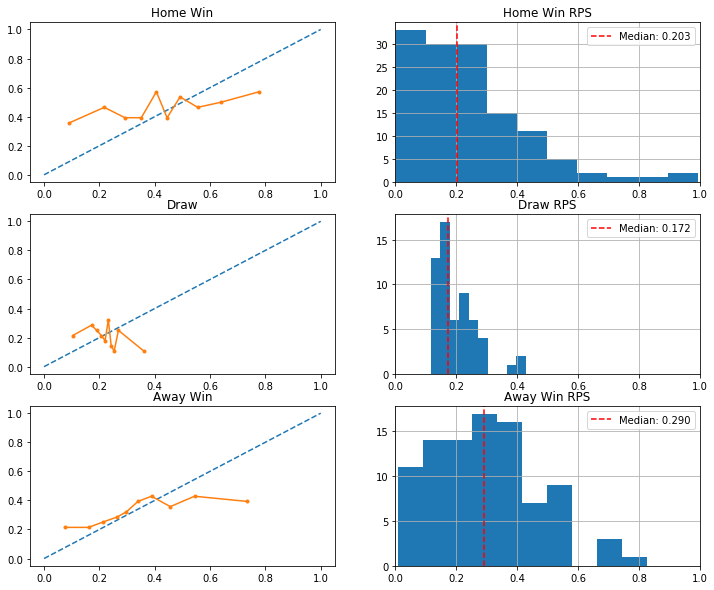

In [25]:
get_model_diagnosis(df_plus)
plt.show();